In [1]:
# ============================================================
# 0. INSTALLS (COLAB)
# ============================================================
!pip install -q xgboost lightgbm shap imbalanced-learn scikit-posthocs pingouin

# ============================================================
# 1. IMPORTS & GLOBAL CONFIG
# ============================================================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine
from scipy import stats
import scikit_posthocs as sp
import pingouin as pg

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.5 MB/s eta 0:00:00


In [2]:
# ============================================================
# 2. LOAD DATASET & REMOVE LEAKY FEATURES
# ============================================================
df = pd.read_csv("/content/LC_66 defaults 4%.csv")
print("✓ CSV loaded:", df.shape)

# Target
y = df['target']

# Leaky features: post-origination payment/performance variables
leaky_features = [
    'out_prncp',              # remaining principal
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_amnt',
    'last_pymnt_d',
    'last_credit_pull_d'
]

# Drop leaky features
df_noleak = df.drop(columns=leaky_features)
print("✓ After removing leaky features:", df_noleak.shape)

# ============================================================
# 3. DATE ENGINEERING (issue_d, earliest_cr_line)
# ============================================================
# We assume issue_d and earliest_cr_line are parseable by pandas
df_noleak['issue_d'] = pd.to_datetime(df_noleak['issue_d'], errors='coerce')
df_noleak['earliest_cr_line'] = pd.to_datetime(df_noleak['earliest_cr_line'], errors='coerce')

# Issue year and month (numeric)
df_noleak['issue_year'] = df_noleak['issue_d'].dt.year
df_noleak['issue_month'] = df_noleak['issue_d'].dt.month

# Credit age in months: issue_d - earliest_cr_line
df_noleak['credit_age_months'] = (
    (df_noleak['issue_d'].dt.year - df_noleak['earliest_cr_line'].dt.year) * 12 +
    (df_noleak['issue_d'].dt.month - df_noleak['earliest_cr_line'].dt.month)
)

# Drop original date strings (keep engineered numeric features)
df_noleak = df_noleak.drop(columns=['issue_d', 'earliest_cr_line'])

print("✓ After date engineering:", df_noleak.shape)

# New feature set
X_full = df_noleak.drop(columns=['target'])
y = df_noleak['target']


✓ CSV loaded: (1647, 50)
✓ After removing leaky features: (1647, 38)
✓ After date engineering: (1647, 39)


In [3]:
# ============================================================
# 4. FEATURE REDUCTION (NON-LEAKY FEATURES ONLY)
# ============================================================
from sklearn.feature_selection import mutual_info_classif

# Categorical features (original LC categorical + engineered if needed)
original_categorical_features = [
    'grade',
    'sub_grade',
    'emp_length',
    'home_ownership',
    'verification_status',
    'pymnt_plan',
    'purpose',
    'addr_state',
    'initial_list_status',
    'policy_code',
    'application_type'
]

# Ensure categorical as string if present
for col in original_categorical_features:
    if col in X_full.columns:
        X_full[col] = X_full[col].astype(str)

def cramers_v(x, y):
    """Cramér's V for categorical feature vs binary target."""
    confusion = pd.crosstab(x, y)
    if confusion.shape[0] < 2 or confusion.shape[1] < 2:
        return 0.0
    chi2 = stats.chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom <= 0:
        return 0.0
    return np.sqrt(phi2corr / denom)

def kruskal_score(x, y):
    """Kruskal–Wallis H-statistic for numeric feature vs binary target."""
    try:
        groups = [x[y == cls] for cls in np.unique(y)]
        if len(groups) < 2:
            return 0.0
        stat, p = stats.kruskal(*groups)
        return stat
    except Exception:
        return 0.0

def compute_feature_scores(X, y, categorical_features):
    """Compute Cramér's V / Kruskal + Mutual Information for all features."""
    scores = {}
    for col in X.columns:
        if col in categorical_features:
            scores[col] = cramers_v(X[col], y)
        else:
            scores[col] = kruskal_score(X[col], y)

    # Mutual Information (factorize to handle mixed types)
    X_factorized = X.apply(lambda s: pd.factorize(s)[0])
    mi = mutual_info_classif(X_factorized, y, discrete_features='auto', random_state=42)
    mi_scores = dict(zip(X.columns, mi))

    return scores, mi_scores

cramer_scores, mi_scores = compute_feature_scores(X_full, y, original_categorical_features)

cramer_norm = pd.Series(cramer_scores).rank(pct=True)
mi_norm = pd.Series(mi_scores).rank(pct=True)

combined_score = 0.5 * cramer_norm + 0.5 * mi_norm
combined_score = combined_score.sort_values(ascending=False)

print("\nTop 20 features by combined statistical score (non-leaky):")
print(combined_score.head(20))

# Select Top-K features (tunable)
TOP_K = 35
selected_features = combined_score.head(TOP_K).index.tolist()
print(f"\nSelected {len(selected_features)} non-leaky features:")
print(selected_features)

# Restrict X to selected features
X = X_full[selected_features]

# Update categorical / numeric lists
categorical_features = [c for c in selected_features if c in original_categorical_features]
numeric_features = [c for c in selected_features if c not in categorical_features]


Top 20 features by combined statistical score (non-leaky):
int_rate                      1.000000
int_rate_times_term           0.960526
collections_12_mths_ex_med    0.881579
revol_util                    0.763158
funded_amnt_inv               0.736842
term                          0.723684
funded_amnt                   0.690789
inq_last_6mths                0.671053
total_rev_hi_lim              0.671053
loan_amnt                     0.651316
sub_grade                     0.618421
grade                         0.605263
installment                   0.578947
dti                           0.565789
dti_squared                   0.565789
open_acc                      0.552632
installment_to_income         0.546053
acc_now_delinq                0.539474
tot_cur_bal                   0.539474
loan_to_income                0.532895
dtype: float64

Selected 35 non-leaky features:
['int_rate', 'int_rate_times_term', 'collections_12_mths_ex_med', 'revol_util', 'funded_amnt_inv', 'term', 'fund

In [4]:
# ============================================================
# 5. PREPROCESSOR (OHE + SCALER) & DOMAIN GROUPS
# ============================================================
cat_categories = [sorted(X[col].unique()) for col in categorical_features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False, categories=cat_categories), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
d = X_processed.shape[1]
print("\nProcessed features after selection:", d)

def build_domain_groups_lc_features(fnames):
    """Domain groups adapted to LC semantics (OHE-aware)."""
    groups = {
        "LoanTerms": [],
        "BorrowerProfile": [],
        "CreditHistory": [],
        "RevolvingCredit": [],
        "PaymentPerformance": [],  # now mostly empty (leaky removed)
        "LoanMetadata": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # Loan Terms & Pricing
        if any(k in lname for k in [
            "loan_amnt", "funded_amnt", "funded_amnt_inv",
            "term", "int_rate", "installment",
            "loan_to_income", "installment_to_income",
            "int_rate_times_term"
        ]):
            groups["LoanTerms"].append(i)

        # Borrower Profile
        elif any(k in lname for k in [
            "emp_length", "home_ownership", "annual_inc",
            "application_type"
        ]):
            groups["BorrowerProfile"].append(i)

        # Credit History
        elif any(k in lname for k in [
            "dti", "dti_squared", "delinq_2yrs",
            "inq_last_6mths",
            "open_acc", "pub_rec", "total_acc",
            "acc_now_delinq", "collections_12_mths_ex_med",
            "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim",
            "credit_age_months"
        ]):
            groups["CreditHistory"].append(i)

        # Revolving Credit
        elif any(k in lname for k in ["revol_bal", "revol_util"]):
            groups["RevolvingCredit"].append(i)

        # Payment Performance (should be mostly empty now)
        elif any(k in lname for k in [
            "out_prncp", "total_pymnt", "total_rec_",
            "recoveries", "collection_recovery_fee",
            "last_pymnt"
        ]):
            groups["PaymentPerformance"].append(i)

        # Loan Metadata
        elif any(k in lname for k in [
            "grade", "sub_grade", "verification_status",
            "pymnt_plan", "purpose",
            "addr_state", "initial_list_status",
            "policy_code", "issue_year", "issue_month"
        ]):
            groups["LoanMetadata"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

domain_groups = build_domain_groups_lc_features(feature_names)
print("\nDomain groups:")
for g, feats in domain_groups.items():
    print(f"  {g}: {len(feats)} features")


Processed features after selection: 137

Domain groups:
  LoanTerms: 9 features
  BorrowerProfile: 13 features
  CreditHistory: 12 features
  RevolvingCredit: 2 features
  LoanMetadata: 101 features


In [5]:
# ============================================================
# RANDOMIZEDSEARCHCV TUNING (LC_66)
# ============================================================
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

def tune_model(X, y, model_name="LGB", n_iter=15):
    print(f"\n=== Tuning {model_name} ===")

    numeric = X.select_dtypes(include=np.number).columns.tolist()
    cat     = X.select_dtypes(exclude=np.number).columns.tolist()

    prep = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat),
        ('num', StandardScaler(), numeric)
    ], remainder='passthrough')

    if model_name == "RF":
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_dist = {
            'clf__n_estimators':     [80, 120, 160, 200, 250],
            'clf__max_depth':        [4, 6, 8, 10, None],
            'clf__min_samples_split':[2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__max_features':     ['sqrt', 'log2', 0.6],
            'clf__class_weight':     ['balanced', None]
        }

    elif model_name == "XGB":
        base_model = xgb.XGBClassifier(random_state=42, eval_metric='auc', verbosity=0)
        param_dist = {
            'clf__n_estimators':     [80, 120, 180, 250],
            'clf__learning_rate':    [0.008, 0.02, 0.05, 0.12],
            'clf__max_depth':        [3, 4, 6, 8],
            'clf__subsample':        [0.65, 0.8, 0.95],
            'clf__colsample_bytree': [0.6, 0.8, 1.0],
            'clf__reg_lambda':       [0.1, 1, 5],
            'clf__scale_pos_weight': [1, 2, 3, 5]
        }

    elif model_name == "LGB":
        base_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
        param_dist = {
            'clf__n_estimators':     [80, 120, 180, 250],
            'clf__learning_rate':    [0.008, 0.02, 0.05, 0.12],
            'clf__max_depth':        [3, 4, 6, 8],
            'clf__num_leaves':       [20, 40, 80, 150],
            'clf__subsample':        [0.65, 0.8, 0.95],
            'clf__colsample_bytree': [0.6, 0.8, 1.0],
            'clf__reg_lambda':       [0.1, 1, 5],
            'clf__class_weight':     ['balanced', None]
        }

    pipe = Pipeline([('prep', prep), ('clf', base_model)])

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=StratifiedKFold(4, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    search.fit(X, y.astype(int))
    print(f"Best {model_name} AUC: {search.best_score_:.4f}")
    print("Best params:", search.best_params_)

    return search.best_estimator_, search.best_params_, search.best_score_


In [6]:
X_tune = X.copy()
y_tune = y.copy()

best_rf, rf_params, rf_auc = tune_model(X_tune, y_tune, "RF")
best_xgb, xgb_params, xgb_auc = tune_model(X_tune, y_tune, "XGB")
best_lgb, lgb_params, lgb_auc = tune_model(X_tune, y_tune, "LGB")

print("\nBest parameters:")
print("RF:", rf_params)
print("XGB:", xgb_params)
print("LGB:", lgb_params)



=== Tuning RF ===
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best RF AUC: 0.7077
Best params: {'clf__n_estimators': 120, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': 4, 'clf__class_weight': 'balanced'}

=== Tuning XGB ===
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best XGB AUC: 0.7199
Best params: {'clf__subsample': 0.65, 'clf__scale_pos_weight': 3, 'clf__reg_lambda': 0.1, 'clf__n_estimators': 120, 'clf__max_depth': 3, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 1.0}

=== Tuning LGB ===
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best LGB AUC: 0.7015
Best params: {'clf__subsample': 0.8, 'clf__reg_lambda': 5, 'clf__num_leaves': 20, 'clf__n_estimators': 80, 'clf__max_depth': 3, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 1.0, 'clf__class_weight': 'balanced'}

Best parameters:
RF: {'clf__n_estimators': 120, 'clf__min_samples_split': 2, 'clf__min_samples_leaf':

In [7]:
def strip_prefix(d, prefix="clf__"):
    return {k.replace(prefix, ""): v for k, v in d.items()}

BEST_PARAMS = {
    'RF': strip_prefix(rf_params),
    'XGB': strip_prefix(xgb_params),
    'LGB': strip_prefix(lgb_params)
}

BEST_PARAMS['RF'].update({'random_state': 42, 'n_jobs': -1})
BEST_PARAMS['XGB'].update({'random_state': 42, 'eval_metric': 'auc', 'verbosity': 0})
BEST_PARAMS['LGB'].update({'random_state': 42, 'verbose': -1})

models = {
    'RF': RandomForestClassifier(**BEST_PARAMS['RF']),
    'XGB': xgb.XGBClassifier(**BEST_PARAMS['XGB']),
    'LGB': lgb.LGBMClassifier(**BEST_PARAMS['LGB'])
}


In [8]:
resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

class_weight_dict = {
    int(cls): float(w)
    for cls, w in zip(np.unique(y), compute_class_weight('balanced', classes=np.unique(y), y=y))
}
print("\nClass weights:", class_weight_dict)



Class weights: {0: 0.5208728652751423, 1: 12.477272727272727}


In [9]:
# ============================================================
# 7. EXPLANATION METHODS (7 EXPLAINERS, INCLUDING BANZHAF)
# ============================================================
def get_shap_reliable(pipe, X_test):
    """SHAP values using TreeExplainer. Returns (n_samples, n_features)."""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"  SHAP failed: {e}")
        n_features = X_proc.shape[1]
        return np.zeros((len(X_test), n_features))

def compute_banzhaf(pipe, X_test, n_samples=3, max_instances=3):
    """
    Approximate Banzhaf values via random coalitions.
    NOTE: This is slow; we keep n_samples and max_instances small.
    """
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def compute_myerson(pipe, X_test, G, alpha=0.5):
    """
    Myerson value: graph-constrained smoothing of SHAP.
    φ_Myerson(i) = (1 - α) * φ_SHAP(i) + α * mean_{j in N(i)} φ_SHAP(j)
    """
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i)) if i in G.nodes() else []
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors if j < d_local])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(30, len(X_test)), 1)), shap_vals, shap_mean

def build_data_groups(X_proc, n_groups=5):
    """Data-driven Owen groups via correlation clustering."""
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        # Clean correlation matrix
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        # Distance matrix for clustering
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=5):
    """Model-driven Owen groups via SHAP correlation clustering."""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_phi(phi, groups):
    """Owen values from base attribution vector φ (group-wise redistribution of |φ|)."""
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

def compute_Q(groups, dep):
    """Group quality Q: mean within-group dependency / mean across-group dependency."""
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except Exception:
        return np.nan

def adaptive_owen_myerson(phi_my):
    """
    R-Myerson (Redistributed Myerson):
    φ_adapt(i) = sign(φ_my(i)) * (sum_j |φ_my(j)| / d)
    """
    d_local = len(phi_my)
    total = np.sum(np.abs(phi_my))
    if d_local == 0:
        return phi_my
    per = total / d_local
    out = np.zeros(d_local)
    for i in range(d_local):
        sign = np.sign(phi_my[i]) if phi_my[i] != 0 else 1
        out[i] = sign * per
    return out

print("\n✓ Explanation methods and group quality defined")



✓ Explanation methods and group quality defined


In [10]:
# ============================================================
# 8. INTERPRETABILITY METRICS & S(α)
# ============================================================
def stability_cv(expl_list):
    """Coefficient of variation (CV) across folds."""
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except Exception:
        return 1.0

def kuncheva_index(expl_list, k=10):
    """Kuncheva index for top-k feature set stability."""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    d_local = None
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            if d_local is None:
                d_local = len(imp)
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except Exception:
            sets.append(set())

    if len(sets) < 2 or d_local is None:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d_local:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d_local) / (k - (k**2)/d_local)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Cosine similarity between mean |φ| vectors across folds."""
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p + 1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """Overall interpretability: I = β(1 - CV) + β * Kuncheva + β * Cosine."""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    """Normalize a pandas Series to [0,1]."""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def performance_interpretability_score(auc_series, I_series, alpha=0.5):
    """S(α) = α * norm(AUC) + (1 - α) * norm(I)."""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

print("\n✓ Interpretability metrics and S(α) defined")


✓ Interpretability metrics and S(α) defined


In [11]:
# ============================================================
# 9. MAIN EXPERIMENT – 7 METHODS, 3-FOLD CV
# ============================================================
print("\n" + "="*80)
print("RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS – LC_66 (NO LEAKAGE)")
print("="*80)

cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = {}
all_records = []
all_explanations = {}

method_order = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'R-Myerson'
]

total_configs = len(models) * len(resamplers)
config_count = 0

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        config_count += 1
        print(f"\n[{config_count}/{total_configs}] Model: {mname} | Sampler: {sname}")

        aucs = []

        shap_runs = []
        banzhaf_runs = []
        myerson_runs = []

        owen_dom_runs = []
        owen_data_runs = []
        owen_model_runs = []
        r_myerson_runs = []

        Q_dom_list = []
        Q_data_list = []
        Q_model_list = []

        for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Myerson graph (train-only)
            X_tr_proc = preprocessor.transform(X_tr)
            corr_tr_my = np.corrcoef(X_tr_proc.T)
            corr_tr_my = np.nan_to_num(corr_tr_my)

            G_myerson = nx.Graph()
            G_myerson.add_nodes_from(range(d))
            for i in range(d):
                for j in range(i + 1, d):
                    if abs(corr_tr_my[i, j]) >= 0.25:
                        G_myerson.add_edge(i, j)

            # Build pipeline
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))

            clf_clone = clone(model)
            steps.append(('clf', clf_clone))
            pipe = ImbPipeline(steps)

            # Cost-sensitive config
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # AUC
            y_proba = pipe.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_te, y_proba)
            aucs.append(auc)
            print(f"  Fold {fold} → AUC: {auc:.4f}")

            # Sample for explanations
            X_sample = X_te.sample(n=min(30, len(X_te)), random_state=42)

            # SHAP
            shap_vals = get_shap_reliable(pipe, X_sample)
            shap_runs.append(shap_vals)

            # Banzhaf
            banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=3, max_instances=3)
            banzhaf_runs.append(banzhaf_vals)

            # Myerson
            myerson_vals, shap_full, shap_mean = compute_myerson(pipe, X_sample, G_myerson)
            myerson_runs.append(myerson_vals)

            # Data-driven groups
            data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)

            # Model-driven groups
            bg_sample = X_tr.sample(n=min(50, len(X_tr)), random_state=42)
            shap_bg = get_shap_reliable(pipe, bg_sample)
            model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)

            # Correlation for domain Q
            corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
            corr_tr = np.nan_to_num(corr_tr, nan=0.0)

            # Base SHAP mean
            phi_shap = shap_full.mean(axis=0)

            # Owen-Domain
            owen_dom_vec = owen_from_phi(phi_shap, domain_groups)
            owen_dom = np.tile(owen_dom_vec, (len(X_sample), 1))
            owen_dom_runs.append(owen_dom)
            Q_dom_list.append(compute_Q(domain_groups, corr_tr))

            # Owen-Data
            owen_data_vec = owen_from_phi(phi_shap, data_groups)
            owen_data = np.tile(owen_data_vec, (len(X_sample), 1))
            owen_data_runs.append(owen_data)
            Q_data_list.append(compute_Q(data_groups, dep_data))

            # Owen-Model
            owen_model_vec = owen_from_phi(phi_shap, model_groups)
            owen_model = np.tile(owen_model_vec, (len(X_sample), 1))
            owen_model_runs.append(owen_model)
            Q_model_list.append(compute_Q(model_groups, dep_mod))

            # R-Myerson
            phi_my = myerson_vals.mean(axis=0)
            adapt_vec = adaptive_owen_myerson(phi_my)
            adapt_om = np.tile(adapt_vec, (len(X_sample), 1))
            r_myerson_runs.append(adapt_om)

        auc_mean = np.mean(aucs)
        print(f"  → Mean AUC: {auc_mean:.4f}")

        method_runs = {
            'SHAP': shap_runs,
            'Banzhaf': banzhaf_runs,
            'Myerson': myerson_runs,
            'Owen-Domain': owen_dom_runs,
            'Owen-Data': owen_data_runs,
            'Owen-Model': owen_model_runs,
            'R-Myerson': r_myerson_runs
        }

        all_explanations[(mname, sname)] = method_runs

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in method_runs.items():
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=10)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 10. METRICS DATAFRAME + S(α)
# ============================================================
metrics = pd.DataFrame(all_records)
metrics['S(α=0.5)'] = performance_interpretability_score(metrics['AUC'], metrics['I'])

print("\n✓ Metrics DataFrame created")
print(metrics.head())
metrics.to_csv("LC66_results_7methods_noleak.csv", index=False)



RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS – LC_66 (NO LEAKAGE)

[1/12] Model: RF | Sampler: None
  Fold 1 → AUC: 0.7694
  Fold 2 → AUC: 0.6261
  Fold 3 → AUC: 0.6908
  Fold 4 → AUC: 0.7449
  → Mean AUC: 0.7078

[2/12] Model: RF | Sampler: SMOTE
  Fold 1 → AUC: 0.7592
  Fold 2 → AUC: 0.6074
  Fold 3 → AUC: 0.6715
  Fold 4 → AUC: 0.7413
  → Mean AUC: 0.6948

[3/12] Model: RF | Sampler: SMOTETomek
  Fold 1 → AUC: 0.7592
  Fold 2 → AUC: 0.6074
  Fold 3 → AUC: 0.6715
  Fold 4 → AUC: 0.7413
  → Mean AUC: 0.6948

[4/12] Model: RF | Sampler: CostSensitive
  Fold 1 → AUC: 0.7626
  Fold 2 → AUC: 0.6280
  Fold 3 → AUC: 0.6700
  Fold 4 → AUC: 0.7457
  → Mean AUC: 0.7016

[5/12] Model: XGB | Sampler: None
  Fold 1 → AUC: 0.7811
  Fold 2 → AUC: 0.6100
  Fold 3 → AUC: 0.7322
  Fold 4 → AUC: 0.7565
  → Mean AUC: 0.7199

[6/12] Model: XGB | Sampler: SMOTE
  Fold 1 → AUC: 0.8152
  Fold 2 → AUC: 0.6223
  Fold 3 → AUC: 0.6877
  Fold 4 → AUC: 0.7742
  → Mean AUC: 0.7249

[7/12] Model: XGB | Sampler:


VISUALIZATIONS – Lending Club(small)


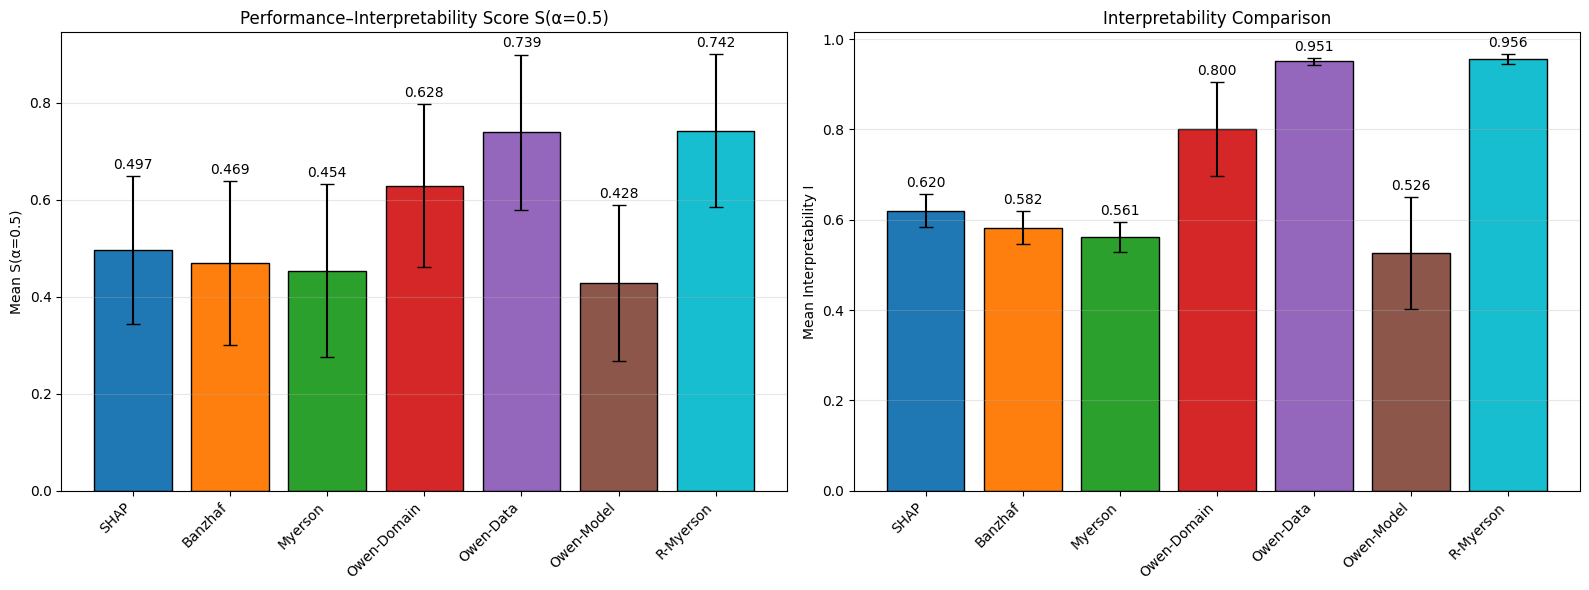

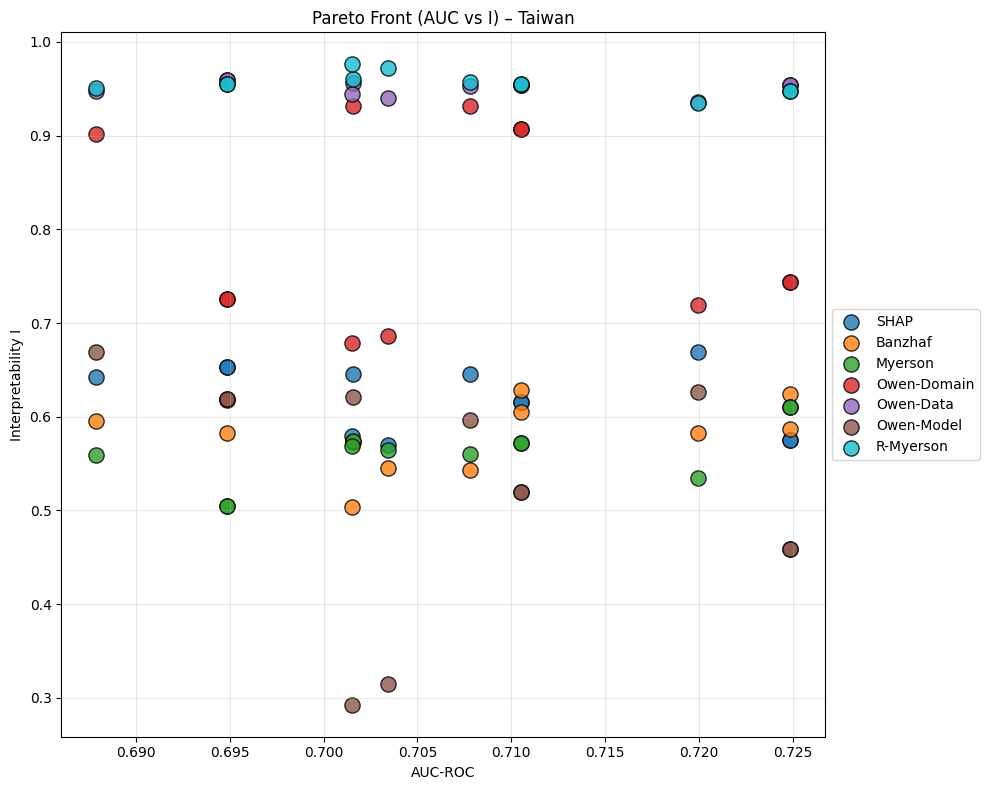

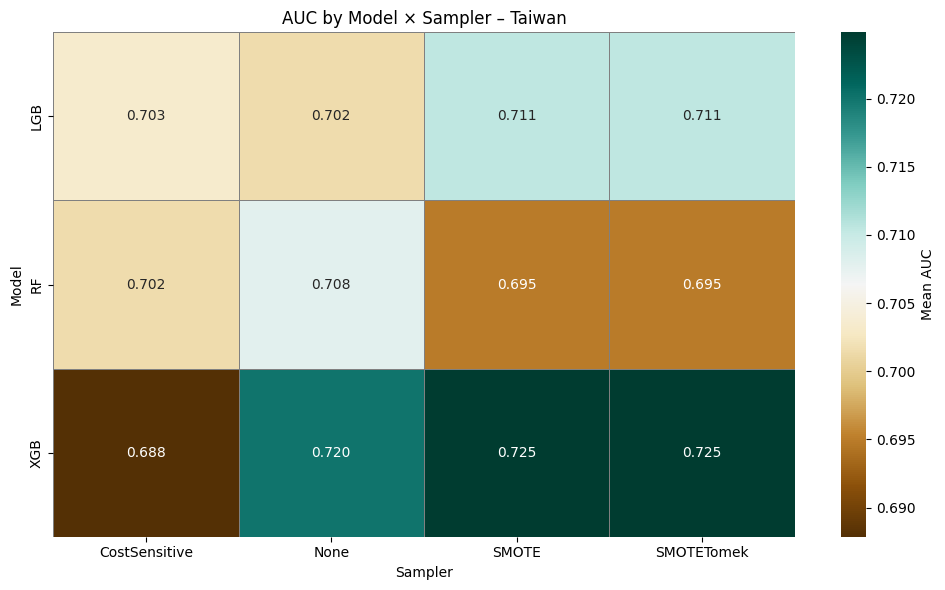

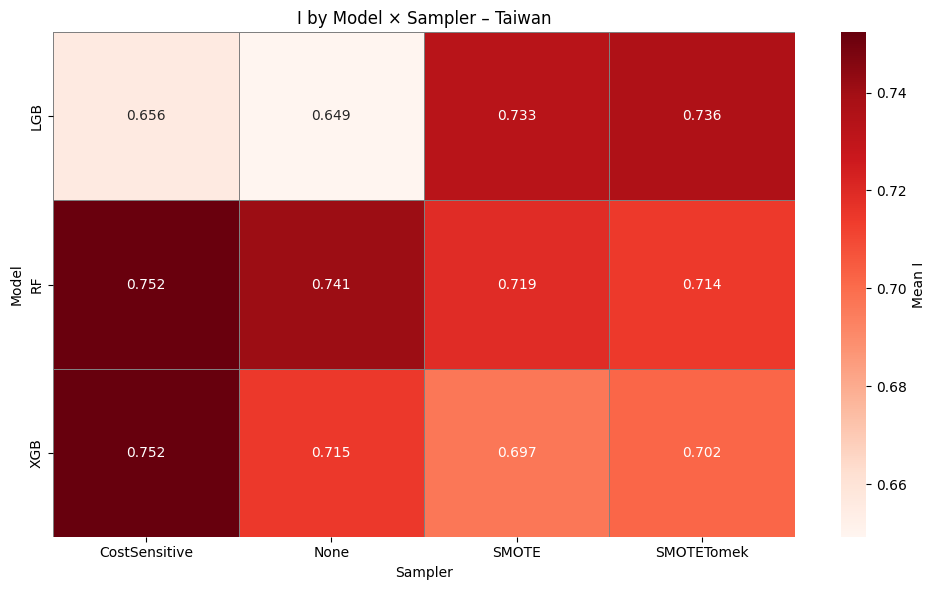

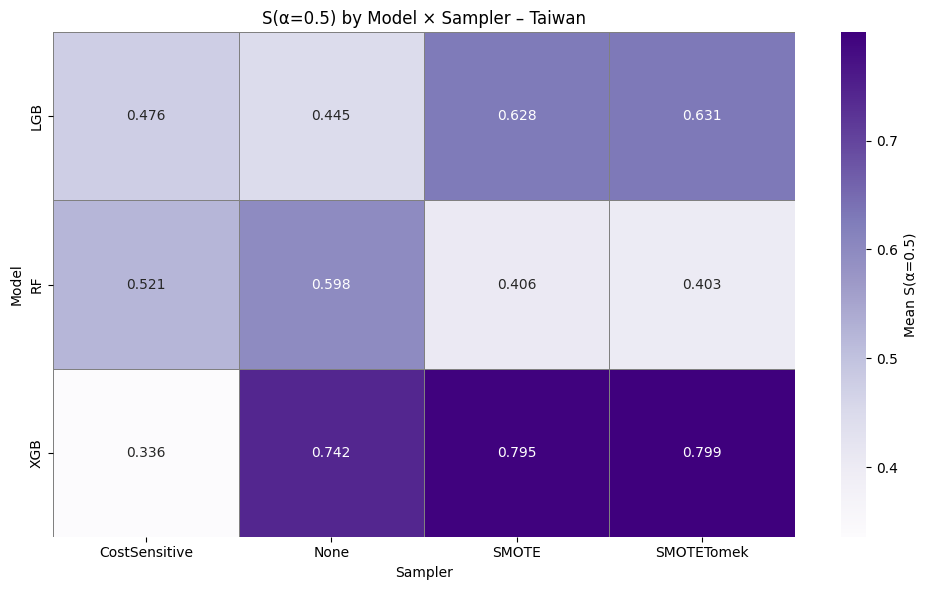

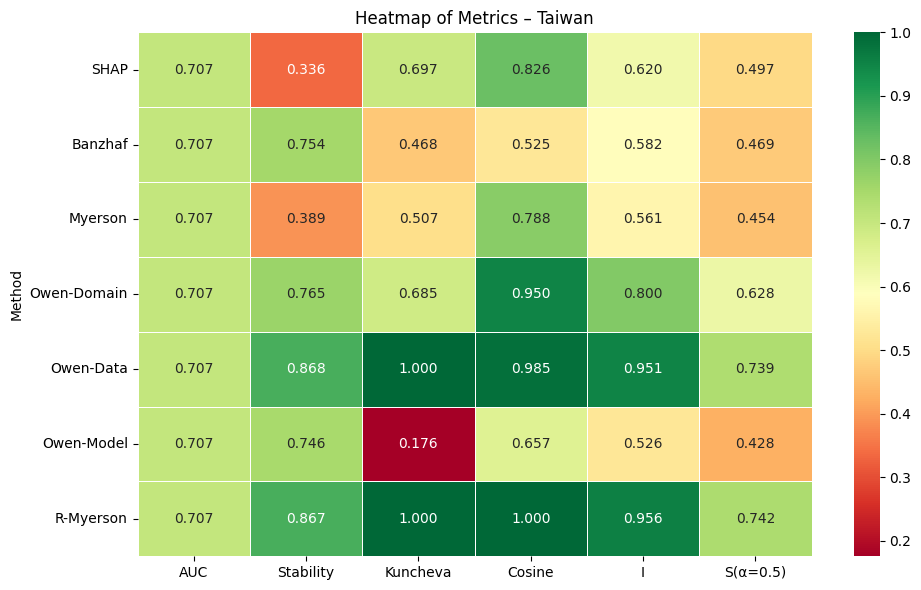

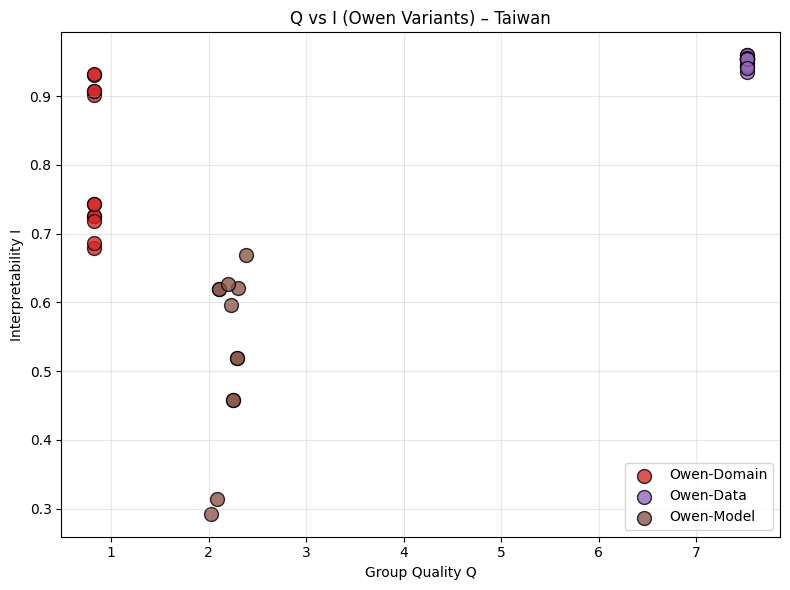

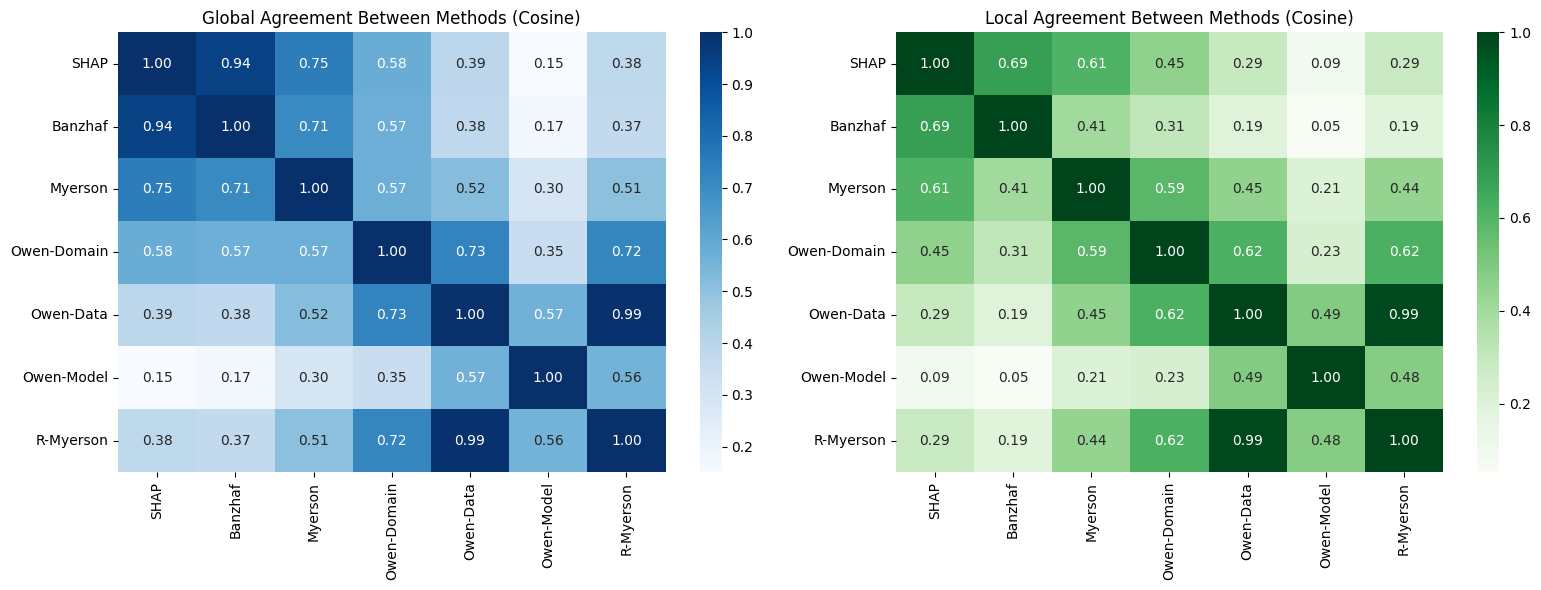


Global Agreement Matrix:
                 SHAP   Banzhaf   Myerson  Owen-Domain  Owen-Data  Owen-Model  \
SHAP         1.000000  0.942118  0.749566     0.580613   0.392706    0.151196   
Banzhaf      0.942118  1.000000  0.706661     0.569548   0.382307    0.172276   
Myerson      0.749566  0.706661  1.000000     0.573357   0.517592    0.297518   
Owen-Domain  0.580613  0.569548  0.573357     1.000000   0.730152    0.353291   
Owen-Data    0.392706  0.382307  0.517592     0.730152   1.000000    0.565018   
Owen-Model   0.151196  0.172276  0.297518     0.353291   0.565018    1.000000   
R-Myerson    0.384719  0.374533  0.507066     0.724468   0.990956    0.556151   

             R-Myerson  
SHAP          0.384719  
Banzhaf       0.374533  
Myerson       0.507066  
Owen-Domain   0.724468  
Owen-Data     0.990956  
Owen-Model    0.556151  
R-Myerson     1.000000  

Local Agreement Matrix:
                 SHAP   Banzhaf   Myerson  Owen-Domain  Owen-Data  Owen-Model  \
SHAP         1.0000

In [15]:
# 9. VISUALIZATIONS
# ============================================================
print("\n" + "="*80)
print("VISUALIZATIONS – Lending Club(small)")
print("="*80)

method_colors = {
    'SHAP':        '#1f77b4',
    'Banzhaf':     '#ff7f0e',
    'Myerson':     '#2ca02c',
    'Owen-Domain': '#d62728',
    'Owen-Data':   '#9467bd',
    'Owen-Model':  '#8c564b',
    'R-Myerson':   '#17becf'
}

model_colors = {
    'RF': '#4C72B0',
    'XGB': '#DD8452',
    'LGB': '#55A868'
}

sampler_colors = {
    'None':          '#5A5A5A',
    'SMOTE':         '#5A3E2B',
    'SMOTETomek':    '#1F3B73',
    'CostSensitive': '#5A2E8A'
}

methods = method_order

# PLOT 1 & 2 – S(α=0.5) and I by method
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
S_means = metrics.groupby("Method")["S(α=0.5)"].mean().reindex(methods)
S_stds  = metrics.groupby("Method")["S(α=0.5)"].std().reindex(methods)
bars = ax.bar(
    S_means.index, S_means.values,
    yerr=S_stds.values,
    color=[method_colors[m] for m in S_means.index],
    edgecolor='black', capsize=5
)
ax.bar_label(bars, fmt="%.3f", padding=3)
ax.set_xticklabels(S_means.index, rotation=45, ha='right')
ax.set_ylabel("Mean S(α=0.5)")
ax.set_title("Performance–Interpretability Score S(α=0.5)")
ax.grid(axis='y', alpha=0.3)

ax = axes[1]
I_means = metrics.groupby("Method")["I"].mean().reindex(methods)
I_stds  = metrics.groupby("Method")["I"].std().reindex(methods)
bars = ax.bar(
    I_means.index, I_means.values,
    yerr=I_stds.values,
    color=[method_colors[m] for m in I_means.index],
    edgecolor='black', capsize=5
)
ax.bar_label(bars, fmt="%.3f", padding=3)
ax.set_xticklabels(I_means.index, rotation=45, ha='right')
ax.set_ylabel("Mean Interpretability I")
ax.set_title("Interpretability Comparison")
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("Lending Club(small)_plot1_2_side_by_side.png", dpi=150)
plt.show()

# PLOT 3 – Pareto front (AUC vs I)
plt.figure(figsize=(10, 8))
for method in methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['AUC'], sub['I'],
                s=120, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("AUC-ROC")
plt.ylabel("Interpretability I")
plt.title("Pareto Front (AUC vs I) – Lending Club(small)")
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('Lending Club(small)_plot3_pareto.png', dpi=150)
plt.show()

# PLOT 4 – AUC heatmap (Model × Sampler)
plt.figure(figsize=(10, 6))
auc_pivot = metrics.pivot_table(
    values='AUC',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)
sns.heatmap(
    auc_pivot,
    annot=True,
    fmt=".3f",
    cmap="BrBG",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean AUC'}
)
plt.title("AUC by Model × Sampler – Lending Club(small)")
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("Lending Club(small)_plot4_auc_heatmap.png", dpi=150)
plt.show()

# PLOT 5 – I heatmap (Model × Sampler)
plt.figure(figsize=(10, 6))
I_pivot = metrics.pivot_table(
    values='I',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)
sns.heatmap(
    I_pivot,
    annot=True,
    fmt=".3f",
    cmap="Reds",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean I'}
)
plt.title("I by Model × Sampler – Lending Club(small)")
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("Lending Club(small)_I_heatmap.png", dpi=150)
plt.show()

# PLOT 6 – S(α=0.5) heatmap (Model × Sampler)
plt.figure(figsize=(10, 6))
S_pivot = metrics.pivot_table(
    values='S(α=0.5)',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)
sns.heatmap(
    S_pivot,
    annot=True,
    fmt=".3f",
    cmap="Purples",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean S(α=0.5)'}
)
plt.title("S(α=0.5) by Model × Sampler – Lending Club(small)")
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("Lending Club(small)_S_heatmap.png", dpi=150)
plt.show()

# PLOT 7 – Heatmap of metrics by method
plt.figure(figsize=(10, 6))
heatmap_data = metrics.groupby("Method")[['AUC', 'Stability', 'Kuncheva', 'Cosine', 'I', 'S(α=0.5)']].mean().reindex(methods)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', linewidths=0.5)
plt.title("Heatmap of Metrics – Lending Club(small)")
plt.tight_layout()
plt.savefig('Lending Club(small)_plot7_heatmap.png', dpi=150)
plt.show()

# PLOT 8 – Q vs I for Owen variants
plt.figure(figsize=(8, 6))
owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
for method in owen_methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['Q'], sub['I'],
                s=100, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("Group Quality Q")
plt.ylabel("Interpretability I")
plt.title("Q vs I (Owen Variants) – Lending Club(small)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('Lending Club(small)_plot8_q_vs_i.png', dpi=150)
plt.show()

# ============================================================
# 10. GLOBAL & LOCAL AGREEMENT (COSINE)
# ============================================================
def plot_global_local_agreement(all_explanations, methods):
    method_names = methods
    M = len(method_names)

    # GLOBAL
    mean_vectors = []
    for method in method_names:
        all_runs = []
        for (mname, sname), method_dict in all_explanations.items():
            all_runs.extend(method_dict[method])
        vec = np.mean([np.abs(e).mean(axis=0) for e in all_runs], axis=0)
        mean_vectors.append(vec)

    G = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            G[i, j] = 1 - cosine(mean_vectors[i], mean_vectors[j])

    # LOCAL
    L = np.zeros((M, M))
    all_runs = [method_dict for (_, _), method_dict in all_explanations.items()]
    for i, mi in enumerate(method_names):
        for j, mj in enumerate(method_names):
            sims = []
            for run in all_runs:
                Ei_list = run[mi]
                Ej_list = run[mj]
                for Ei, Ej in zip(Ei_list, Ej_list):
                    for vi, vj in zip(Ei, Ej):
                        sims.append(1 - cosine(np.abs(vi), np.abs(vj)))
            L[i, j] = np.mean(sims)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(
        G, annot=True, cmap="Blues",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f", ax=axes[0]
    )
    axes[0].set_title("Global Agreement Between Methods (Cosine)")

    sns.heatmap(
        L, annot=True, cmap="Greens",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f", ax=axes[1]
    )
    axes[1].set_title("Local Agreement Between Methods (Cosine)")

    plt.tight_layout()
    plt.savefig("Lending Club(small)_global_local_agreement.png", dpi=150)
    plt.show()

    print("\nGlobal Agreement Matrix:")
    print(pd.DataFrame(G, index=method_names, columns=method_names))
    print("\nLocal Agreement Matrix:")
    print(pd.DataFrame(L, index=method_names, columns=method_names))

plot_global_local_agreement(all_explanations, methods)



In [16]:
# ============================================================
# 11. STATISTICAL ANALYSIS (FRIEDMAN, NEMENYI, WILCOXON, CORR)
# ============================================================
print("\n==================== STATISTICAL ANALYSIS – Lending Club(small) ====================\n")

results_full = metrics.copy()
alpha = 0.05

def tick(p):
    return "✓" if p < alpha else "✗"

def effect_label(delta):
    d_abs = abs(delta)
    if d_abs < 0.147:
        return "negligible"
    elif d_abs < 0.33:
        return "small"
    elif d_abs < 0.474:
        return "medium"
    else:
        return "large"

def cliffs_delta(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    n1 = len(x)
    n2 = len(y)
    if n1 == 0 or n2 == 0:
        return np.nan
    diffs = x.reshape(-1, 1) - y.reshape(1, -1)
    n_greater = np.sum(diffs > 0)
    n_less = np.sum(diffs < 0)
    return (n_greater - n_less) / (n1 * n2)

pivot_T = results_full.pivot_table(
    values='S(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method'
)

complete_methods = pivot_T.dropna(axis=1).columns.tolist()
print("Methods included:", complete_methods, "\n")

# 1. Friedman
print("=== Friedman Test ===")
fried_stat, fried_p = stats.friedmanchisquare(
    *[pivot_T[m].values for m in complete_methods]
)
print(f"χ²={fried_stat:.4f}, p={fried_p:.6f} {tick(fried_p)}\n")

# 2. Nemenyi
if fried_p < alpha:
    print("=== Nemenyi Post-hoc ===")
    nemenyi_p = sp.posthoc_nemenyi_friedman(pivot_T[complete_methods].values)
    nemenyi_p.index = complete_methods
    nemenyi_p.columns = complete_methods
    print(nemenyi_p)
    nemenyi_p.to_csv("Lending Club(small)_nemenyi_results.csv")
else:
    print("Friedman not significant → skipping Nemenyi.\n")

# 3. Wilcoxon + Cliff's delta
print("\n=== Wilcoxon + Cliff's Delta ===")
rows = []
for i in range(len(complete_methods)):
    for j in range(i + 1, len(complete_methods)):
        m1, m2 = complete_methods[i], complete_methods[j]
        x = pivot_T[m1].values
        y = pivot_T[m2].values
        stat, p = stats.wilcoxon(x, y)
        delta = cliffs_delta(x, y)
        rows.append({
            'Method1': m1,
            'Method2': m2,
            'Wilcoxon_stat': stat,
            'p_value': p,
            'Significant': tick(p),
            "Cliff's_delta": delta,
            'Effect_size': effect_label(delta)
        })

wilcoxon_df = pd.DataFrame(rows)
print(wilcoxon_df)
wilcoxon_df.to_csv("Lending Club(small)_wilcoxon_cliffs_results.csv", index=False)

# 4. Correlation AUC vs I
print("\n=== Correlation AUC vs I ===")
rho_s, p_s = stats.spearmanr(results_full['AUC'], results_full['I'])
tau_k, p_k = stats.kendalltau(results_full['AUC'], results_full['I'])

print(f"Spearman ρ={rho_s:.3f}, p={p_s:.6f} {tick(p_s)}")
print(f"Kendall τ={tau_k:.3f}, p={p_k:.6f} {tick(p_k)}")

pd.DataFrame([{
    'Spearman_rho': rho_s,
    'Spearman_p': p_s,
    'Kendall_tau': tau_k,
    'Kendall_p': p_k
}]).to_csv("Lending Club(small)_auc_I_correlation.csv", index=False)

print("\n✓ Statistical analysis complete.\n")



==================== STATISTICAL ANALYSIS – Lending Club(small) ====================

Methods included: ['Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'R-Myerson', 'SHAP'] 

=== Friedman Test ===
χ²=61.4286, p=0.000000 ✓

=== Nemenyi Post-hoc ===
              Banzhaf   Myerson  Owen-Data  Owen-Domain  Owen-Model  \
Banzhaf      1.000000  0.999958   0.000075     0.040096    0.999958   
Myerson      0.999958  1.000000   0.000018     0.016405    1.000000   
Owen-Data    0.000075  0.000018   1.000000     0.678270    0.000018   
Owen-Domain  0.040096  0.016405   0.678270     1.000000    0.016405   
Owen-Model   0.999958  1.000000   0.000018     0.016405    1.000000   
R-Myerson    0.000030  0.000007   0.999996     0.551194    0.000007   
SHAP         0.841451  0.678270   0.016405     0.615492    0.678270   

             R-Myerson      SHAP  
Banzhaf       0.000030  0.841451  
Myerson       0.000007  0.678270  
Owen-Data     0.999996  0.016405  
Owen-Domain   0.551194  0